## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [71]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
#loading in the dataset
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

In [72]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
sales_channel,50000.0,1.112360,0.315812,1.00,1.00,1.00,1.00,2.0
trip_type,50000.0,1.017800,0.181559,1.00,1.00,1.00,1.00,3.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
flight_day,50000.0,3.814420,1.992792,1.00,2.00,4.00,5.00,7.0
route,50000.0,391.905800,227.297259,0.00,203.00,381.00,611.00,798.0
booking_origin,50000.0,38.263340,32.756539,0.00,4.00,37.00,57.00,103.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [6]:
#displaying the number of rows and columns
df.shape

(50000, 14)

### Univariate Analysis

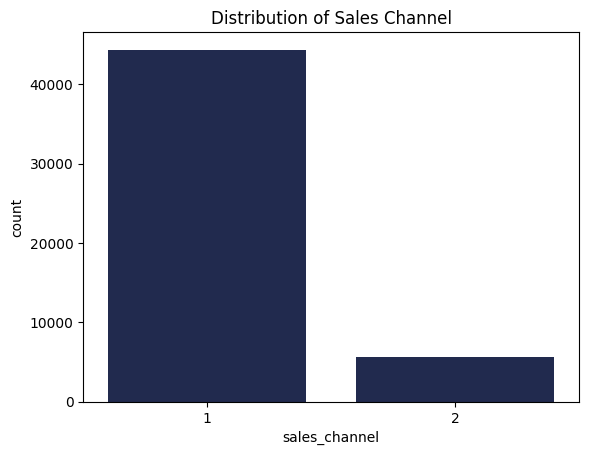

In [75]:
sns.countplot(x=df["sales_channel"], color="#192655")
plt.title("Distribution of Sales Channel");

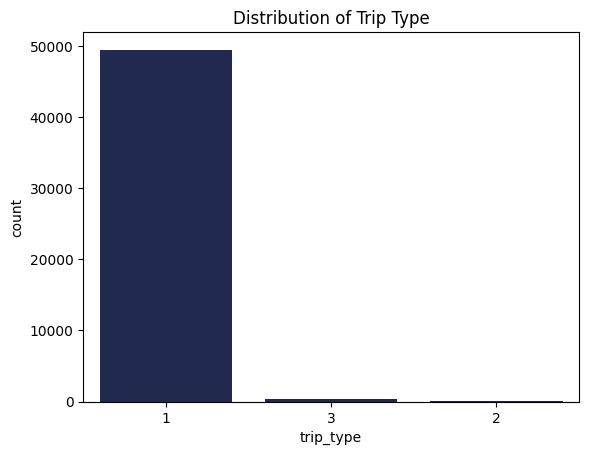

In [76]:
sns.countplot(x=df["trip_type"], order=df["trip_type"].value_counts(ascending=False).index.to_list(), color="#192655")
plt.title("Distribution of Trip Type");

In [9]:
df["route"].value_counts()

route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

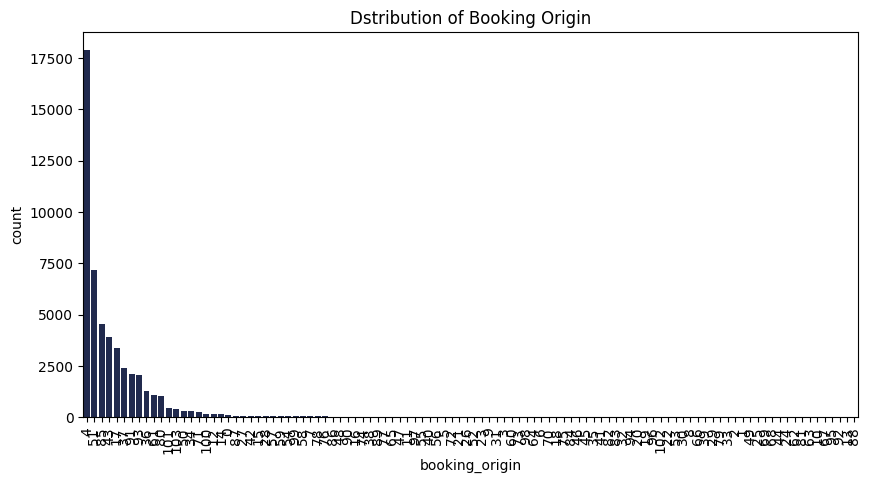

In [77]:
plt.figure(figsize=(10,5))
sns.countplot(x=df["booking_origin"], order=df.booking_origin.value_counts(ascending=False).index.to_list(), color="#192655")
plt.xticks(rotation=90)
plt.title("Dstribution of Booking Origin");

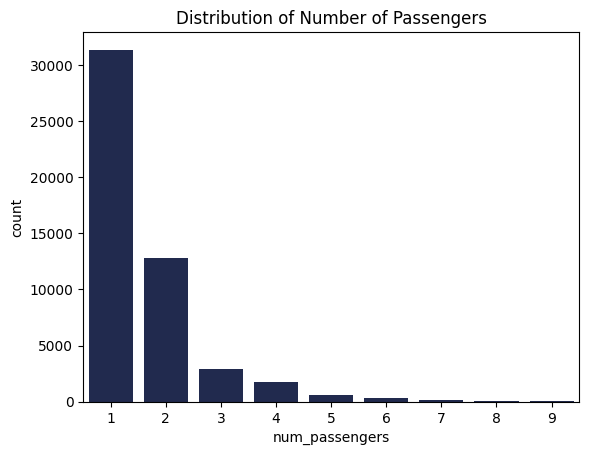

In [78]:
sns.countplot(x=df["num_passengers"], color="#192655")
plt.title("Distribution of Number of Passengers");

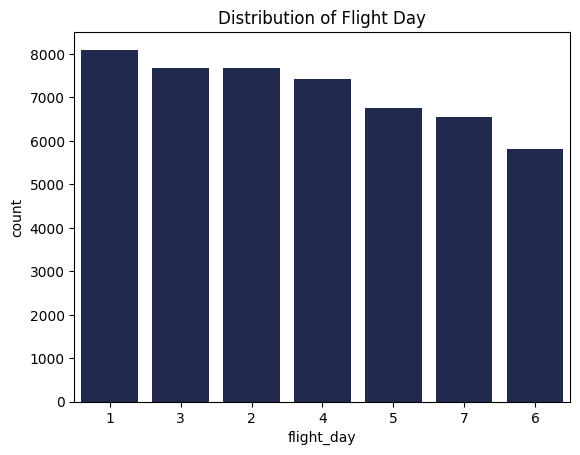

In [79]:
sns.countplot(x=df["flight_day"], order=df.flight_day.value_counts(ascending=False).index.to_list(), color="#192655")
plt.title("Distribution of Flight Day");

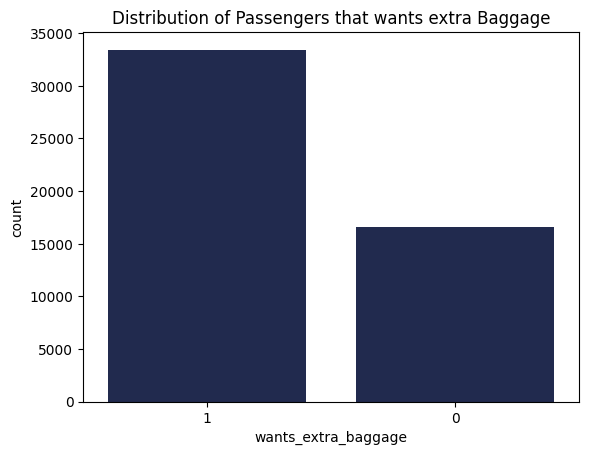

In [80]:
sns.countplot(x=df["wants_extra_baggage"], order=df["wants_extra_baggage"].value_counts(ascending=False).index.to_list(), color="#192655")
plt.title("Distribution of Passengers that wants extra Baggage");

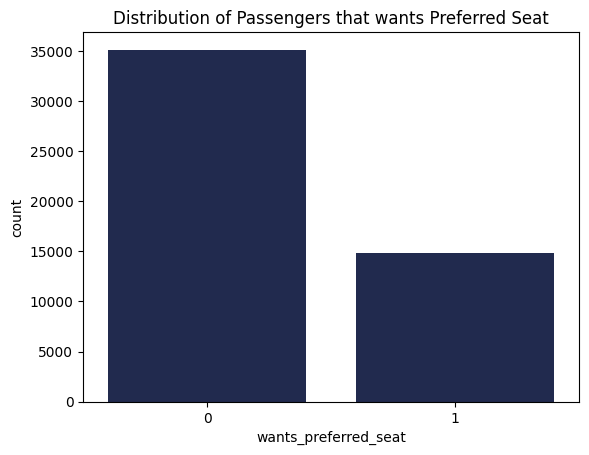

In [81]:
sns.countplot(x=df["wants_preferred_seat"], color="#192655")
plt.title("Distribution of Passengers that wants Preferred Seat");

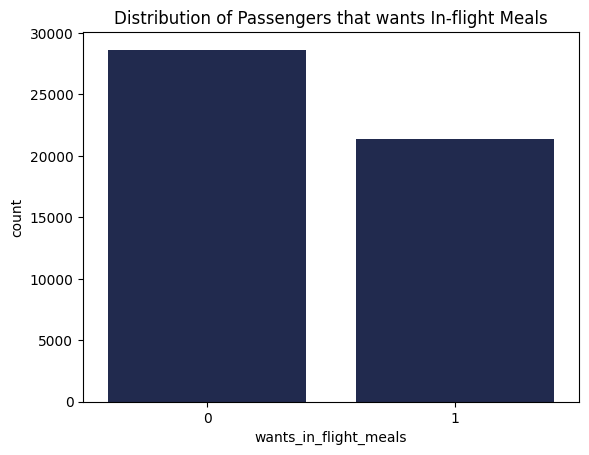

In [82]:
sns.countplot(x=df["wants_in_flight_meals"], color="#192655")
plt.title("Distribution of Passengers that wants In-flight Meals");

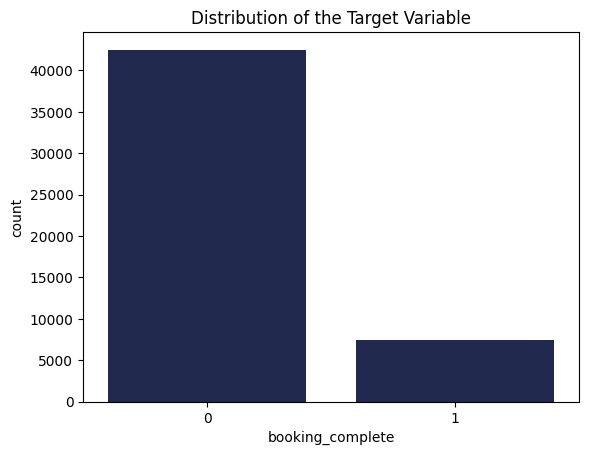

In [83]:
sns.countplot(x=df["booking_complete"], color="#192655")
plt.title("Distribution of the Target Variable");

### Multivariate Analysis

In [86]:
base_color = ["#192655", "#3876BF", "#E1AA74"]
sns.set_palette(base_color)

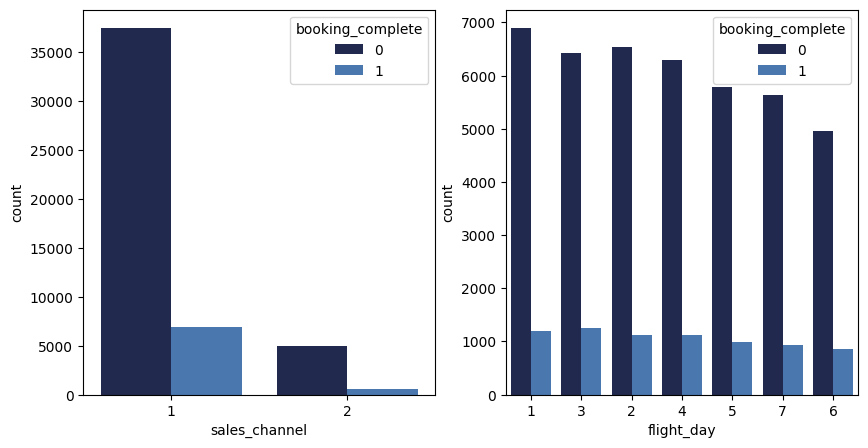

In [87]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=df["sales_channel"], hue=df["booking_complete"])

plt.subplot(1,2,2)
sns.countplot(x=df["flight_day"], hue=df["booking_complete"], order=df.flight_day.value_counts(ascending=False).index.to_list());


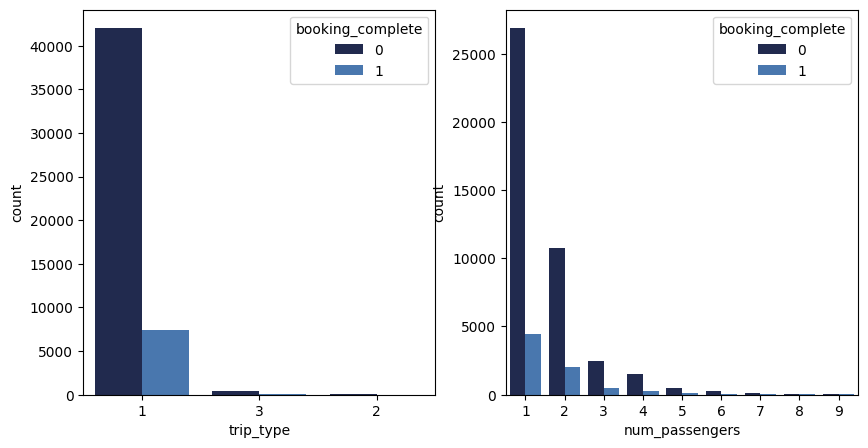

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=df["trip_type"], hue=df["booking_complete"], order=df.trip_type.value_counts(ascending=False).index.to_list())

plt.subplot(1,2,2)
sns.countplot(x=df["num_passengers"], hue=df["booking_complete"]);


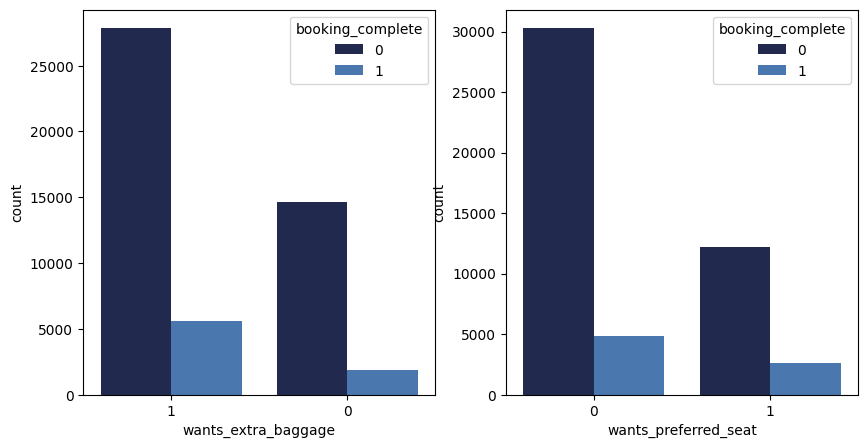

In [91]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=df["wants_extra_baggage"], hue=df["booking_complete"], order=df["wants_extra_baggage"].value_counts(ascending=False).index.to_list())

plt.subplot(1,2,2)
sns.countplot(x=df["wants_preferred_seat"], hue=df["booking_complete"]);


### Data Preprocessing

In [21]:
mapping1 = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping1)

In [22]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [23]:
mapping2 = {
    "RoundTrip": 1,
    "CircleTrip": 2,
    "OneWay": 3
}
df["trip_type"] = df["trip_type"].map(mapping2)

In [24]:
mapping3 = {
    "Internet": 1,
    "Mobile": 2
}
df["sales_channel"] = df["sales_channel"].map(mapping3)

In [25]:
col_to_encode = ["route", "booking_origin"]
label_encoder = LabelEncoder()
for col in col_to_encode:
    df[col] = label_encoder.fit_transform(df[col])

In [26]:
df["booking_complete"].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [27]:
from imblearn.over_sampling import SMOTE
df_oversample = df[df["booking_complete"] == 1]
df_majority = df[df["booking_complete"] == 0]
df_oversample = pd.concat([df_oversample] * 6, ignore_index=True)
balanced_df = pd.concat([df_majority, df_oversample], ignore_index=True)

In [28]:
balanced_df["booking_complete"].value_counts()

booking_complete
1    44868
0    42522
Name: count, dtype: int64

In [29]:
balanced_df.shape

(87390, 14)

## Feature Selection

In [30]:
X = balanced_df.drop(columns=["booking_complete"])
y = balanced_df["booking_complete"]

In [33]:
f_scores, p_values = f_classif(X, y)
f_scores_df = pd.DataFrame({"Feature_Name": X.columns, "f_score": f_scores, "p_values": p_values})
f_scores_df.sort_values(by="f_score", ascending=False, inplace=True)
print(f_scores_df)

             Feature_Name      f_score       p_valies
8          booking_origin  3379.954819   0.000000e+00
12        flight_duration  1916.058184   0.000000e+00
9     wants_extra_baggage   851.219789  3.111122e-186
10   wants_preferred_seat   415.354080   4.105761e-92
1           sales_channel   324.371057   2.187839e-72
4          length_of_stay   308.846493   5.122796e-69
2               trip_type   176.857748   2.575024e-40
11  wants_in_flight_meals   119.930559   6.831044e-28
0          num_passengers    96.100399   1.121856e-22
3           purchase_lead    84.582427   3.763225e-20
7                   route    11.770417   6.020732e-04
5             flight_hour     8.964852   2.753000e-03
6              flight_day     8.458866   3.633597e-03


In [34]:
p_values_df = pd.Series(p_values, index = X.columns)
p_values_df.sort_values(ascending=False, inplace=True)
print(p_values_df)

flight_day                3.633597e-03
flight_hour               2.753000e-03
route                     6.020732e-04
purchase_lead             3.763225e-20
num_passengers            1.121856e-22
wants_in_flight_meals     6.831044e-28
trip_type                 2.575024e-40
length_of_stay            5.122796e-69
sales_channel             2.187839e-72
wants_preferred_seat      4.105761e-92
wants_extra_baggage      3.111122e-186
booking_origin            0.000000e+00
flight_duration           0.000000e+00
dtype: float64


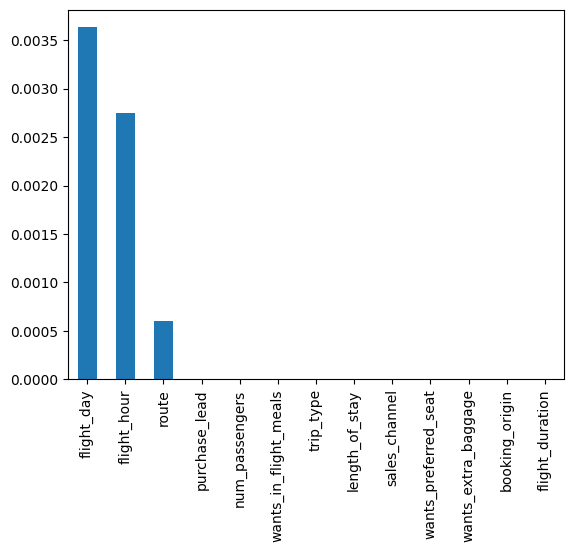

In [35]:
p_values_df.plot.bar();

In [36]:
X.drop(columns=["flight_day", "flight_hour", "route"], axis=1, inplace=True)

In [37]:
print(X.shape)
print(y.shape)

(87390, 10)
(87390,)


In [38]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [39]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
2,trip_type,23.532937
9,flight_duration,18.728105
1,sales_channel,12.154918
6,wants_extra_baggage,3.666086
0,num_passengers,3.626125
5,booking_origin,2.867123
8,wants_in_flight_meals,2.081219
3,purchase_lead,1.970360
7,wants_preferred_seat,1.694693
4,length_of_stay,1.512484


In [40]:
X.drop(columns=["trip_type"], axis=1, inplace=True)
X.head()

,num_passengers,sales_channel,purchase_lead,length_of_stay,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,2,1,262,19,61,1,0,0,5.52
1,1,1,112,20,61,0,0,0,5.52
2,2,1,243,22,36,1,1,0,5.52
3,1,1,96,31,61,0,0,1,5.52
4,2,1,68,22,36,1,0,1,5.52


In [41]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [42]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
8,flight_duration,11.926121
1,sales_channel,10.143912
5,wants_extra_baggage,3.598139
0,num_passengers,3.538857
4,booking_origin,2.719984
7,wants_in_flight_meals,2.081084
2,purchase_lead,1.970221
6,wants_preferred_seat,1.693512
3,length_of_stay,1.511098


In [43]:
X.drop(columns=["flight_duration"], axis=1, inplace=True)
X.head()

,num_passengers,sales_channel,purchase_lead,length_of_stay,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,2,1,262,19,61,1,0,0
1,1,1,112,20,61,0,0,0
2,2,1,243,22,36,1,1,0
3,1,1,96,31,61,0,0,1
4,2,1,68,22,36,1,0,1


In [44]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [45]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
1,sales_channel,5.513305
5,wants_extra_baggage,3.477298
0,num_passengers,3.458722
4,booking_origin,2.702397
7,wants_in_flight_meals,2.025937
2,purchase_lead,1.902565
6,wants_preferred_seat,1.689493
3,length_of_stay,1.438815


In [46]:
X.head()

,num_passengers,sales_channel,purchase_lead,length_of_stay,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,2,1,262,19,61,1,0,0
1,1,1,112,20,61,0,0,0
2,2,1,243,22,36,1,1,0
3,1,1,96,31,61,0,0,1
4,2,1,68,22,36,1,0,1


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
print("X_train is: ", X_train.shape)
print("y_train is : ", y_train.shape)
print("-----------------------")
print("X_test is: ", X_test.shape)
print("y_test is: ", y_test.shape)

X_train is:  (61173, 8)
y_train is :  (61173,)
-----------------------
X_test is:  (26217, 8)
y_test is:  (26217,)


('DTC', array([0.88998774, 0.89546383, 0.88704536, 0.88311264, 0.88907961]), 0.888938, 0.004031)
('RFC', array([0.9041275 , 0.90584389, 0.89979567, 0.90068661, 0.89790747]), 0.901672, 0.002902)
('GBC', array([0.69775235, 0.70641602, 0.69955047, 0.69870852, 0.70443028]), 0.701372, 0.003415)
('ADBC', array([0.68794442, 0.69530037, 0.6903964 , 0.6841589 , 0.69903547]), 0.691367, 0.00527)
('XGB', array([0.73894565, 0.74801798, 0.7503065 , 0.73655387, 0.75453654]), 0.745672, 0.00684)
('LGB', array([0.72341643, 0.72545975, 0.72349816, 0.72028772, 0.72739905]), 0.724012, 0.002369)
('CBC', array([0.73281569, 0.74196976, 0.73534941, 0.73017819, 0.74113127]), 0.736289, 0.004605)
('SVC', array([0.66031876, 0.66595832, 0.66890069, 0.6598823 , 0.67091712]), 0.665195, 0.004451)
('GNB', array([0.60907233, 0.61536575, 0.60833674, 0.61296387, 0.62089259]), 0.613326, 0.004572)
('LGR', array([0.6179812 , 0.62607274, 0.61364937, 0.61770476, 0.62473435]), 0.620028, 0.004668)
('KNC', array([0.74450347, 0.75

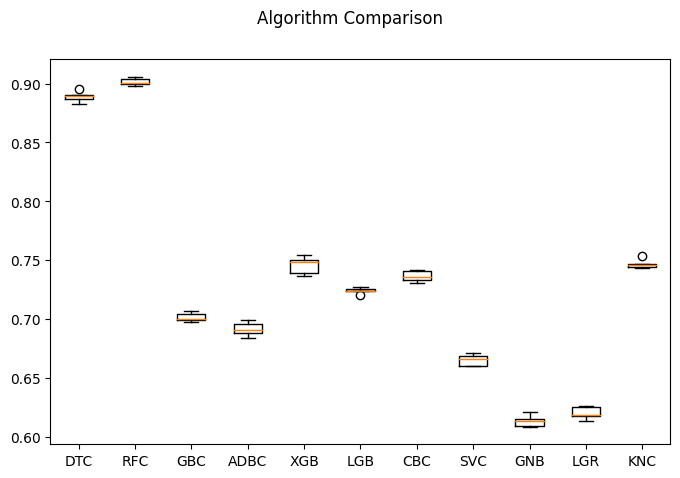

In [51]:
#Comparing Multiple Algorithms

models = []
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('ADBC', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('LGB', LGBMClassifier()))
models.append(('CBC', CatBoostClassifier()))
models.append(('SVC', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('LGR', LogisticRegression()))
models.append(('KNC', KNeighborsClassifier()))



numFolds = 5
# evaluate each model in turn
score = []
names = []

for name, model in models:


  kfold = KFold(n_splits=numFolds, shuffle=True, random_state=42)
  cv_results = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
  score.append(cv_results)
  names.append(name)
  msg = (name, cv_results, round(cv_results.mean(), 6), round(cv_results.std(), 6))




  print(msg)


# boxplot algorithm comparison
fig = plt.figure(figsize=(8,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(score)
ax.set_xticklabels(names)
plt.show()

In [64]:
AccuracyScore1 = []
f1score1 =[]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_RFC = RandomForestClassifier()
    model_RFC.fit(X_train,y_train)
    pred_RFC = model_RFC.predict(X_test)
    acc_score1= accuracy_score(y_test, pred_RFC)
    f1_1= f1_score(y_test, pred_RFC)

    
AccuracyScore1.append(acc_score1)
f1score1.append(f1_1)

mean_accuracy = np.mean(AccuracyScore1)
mean_f1 = np.mean(f1score1)

print(f"Mean Accuracy is: , {mean_accuracy}")
print(f"Mean F1 Score is: , {f1score1}")


Mean Accuracy is: , 0.9300263188007781
Mean F1 Score is: , [0.9355535648416504]


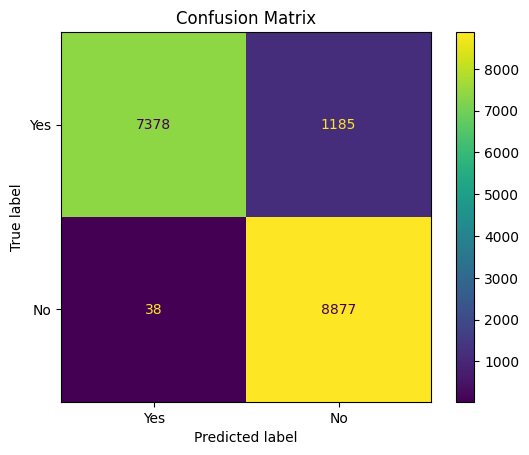

In [65]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pred_RFC)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Yes", "No"])
cm_display.plot()
plt.title("Confusion Matrix");

In [67]:
AccuracyScore2 = []
f1score2 =[]


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_DTC = DecisionTreeClassifier()
    model_DTC.fit(X_train,y_train)
    pred_DTC = model_DTC.predict(X_test)
    acc_score2= accuracy_score(y_test, pred_DTC)
    f1_2= f1_score(y_test, pred_DTC)
    
    
AccuracyScore2.append(acc_score2)
f1score2.append(f1_2)


print("Accuracy Score is: ", np.mean(AccuracyScore2))
print("F1 Score is: ", np.mean(f1score2))


Accuracy Score is:  0.9168097036274173
F1 Score is:  0.9242471605710117


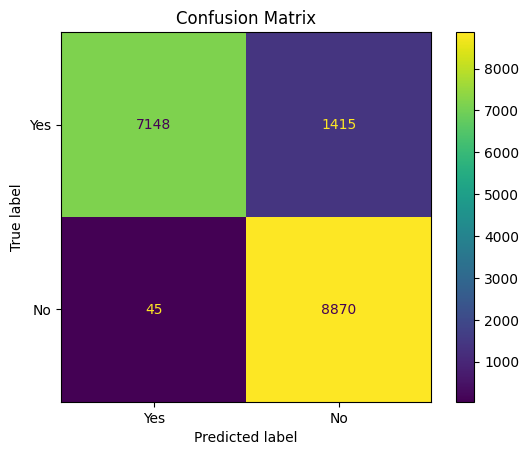

In [57]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pred_DTC)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["Yes", "No"])
cm_display.plot()
plt.title("Confusion Matrix");

In [68]:
print(classification_report(y_test, pred_RFC))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      8563
           1       0.88      1.00      0.94      8915

    accuracy                           0.93     17478
   macro avg       0.94      0.93      0.93     17478
weighted avg       0.94      0.93      0.93     17478



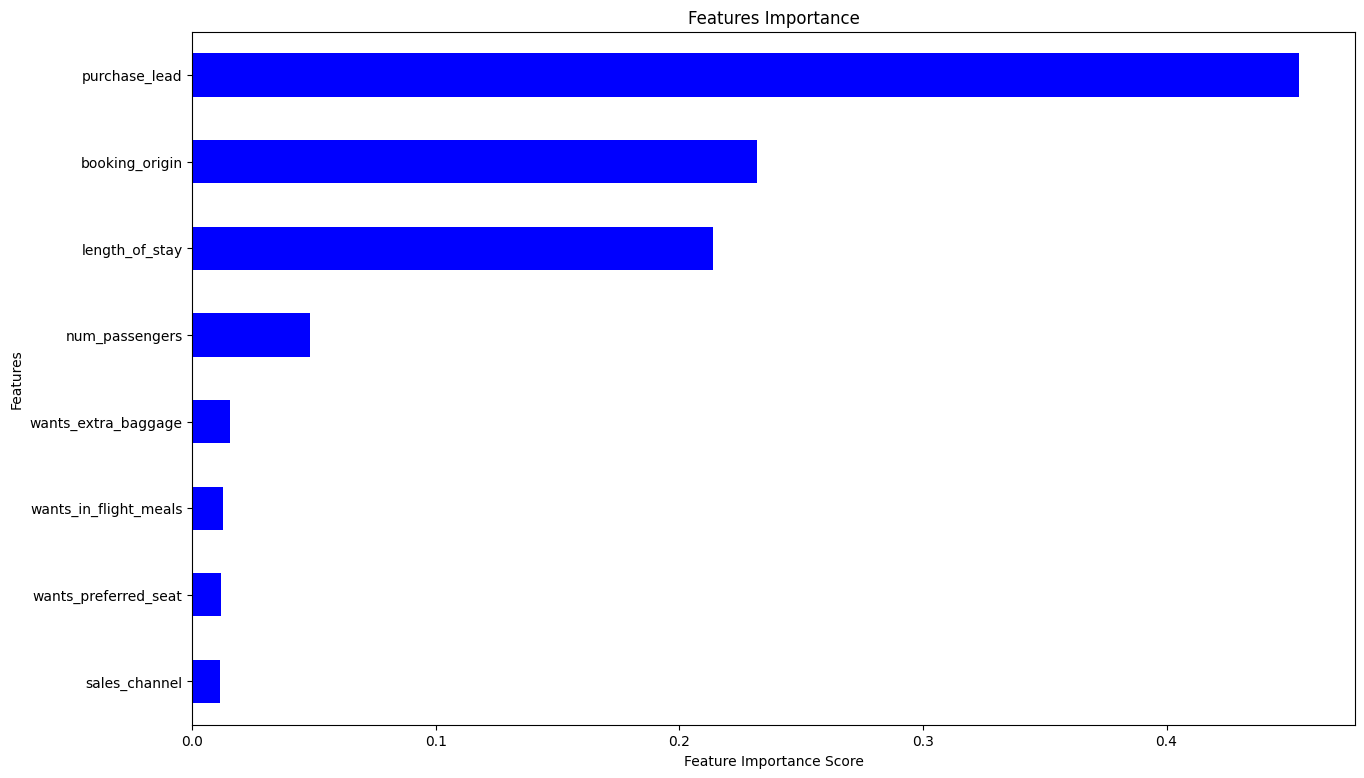

In [70]:
fig, ax = plt.subplots(figsize=[15, 9])
feature_scores = pd.Series(model_RFC.feature_importances_, index=X_train.columns).sort_values()
feature_scores.plot(kind="barh", color= "blue", title="Features Importance",
                    xlabel="Feature Importance Score", ylabel="Features", ax=ax);